<center><h1>2-ab: Introduction to Neural Networks</h1></center>

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>


In [2]:
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/2-ab.zip
!unzip -j 2-ab.zip
!wget https://github.com/rdfia/rdfia.github.io/raw/master/code/2-ab/utils-data.py

--2022-11-18 08:11:53--  https://github.com/rdfia/rdfia.github.io/raw/master/data/2-ab.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/2-ab.zip [following]
--2022-11-18 08:11:53--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/2-ab.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13423991 (13M) [application/zip]
Saving to: ‘2-ab.zip’

2-ab.zip            100%[===================>]  12.80M  --.-KB/s    in 0.05s   

2022-11-18 08:11:54 (241 MB/s) - ‘2-ab.zip’ saved [13423991/13423991]

Archive:  2-ab.zip
  inflating: ._2-ab            

In [3]:
import math
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%run 'utils-data.py'

# Part 1 : Forward and backward passes "by hands"

In [4]:
def init_params(nx, nh, ny):
    """
    nx, nh, ny: integers
    out params: dictionnary
    """
    params = {}
    
    #####################
    ## Your code here  ##
    #####################
    # fill values for Wh, Wy, bh, by

    rand = torch.distributions.Normal(0, 0.3)
    
    params["Wh"] = rand.sample((nh, nx))
    params["Wy"] = rand.sample((ny, nh))
    params["bh"] = rand.sample((1, nh))
    params["by"] = rand.sample((1, ny))
    
    ####################
    ##      END        #
    ####################
    return params

In [5]:
def forward(params, X):
    """
    params: dictionnary
    X: (n_batch, dimension)
    """
    bsize = X.size(0)
    nh = params['Wh'].size(0)
    ny = params['Wy'].size(0)
    outputs = {}

    #####################
    ## Your code here  ##
    #####################
    # fill values for X, htilde, h, ytilde, yhat
    
    outputs["X"] = X
    outputs["htilde"] = (torch.mm(X, params["Wh"].t())
                        + params["bh"].repeat(bsize, 1))
    outputs["h"] = torch.tanh(outputs["htilde"])
    outputs["ytilde"] = (torch.mm(outputs["h"], params["Wy"].t())
                        + params["by"].repeat(bsize, 1))
    outputs["yhat"] = (torch.exp(outputs["ytilde"])
                      / torch.exp(outputs["ytilde"]).sum(1, keepdim=True))
    
    ####################
    ##      END        #
    ####################

    return outputs['yhat'], outputs

In [6]:
def loss_accuracy(Yhat, Y):

    #####################
    ## Your code here  ##
    #####################

    l = -torch.sum(Y * torch.log(Yhat), 1)
    L = torch.mean(l)

    _, Ypred = torch.max(Yhat, 1)
    _, Ygt = torch.max(Y, 1) # gt = Ground Truth
    acc = torch.mean(Ypred == Ygt, dtype=float)

    ####################
    ##      END        #
    ####################

    return L, acc

In [7]:
def backward(params, outputs, Y):
    bsize = Y.shape[0]
    grads = {}

    #####################
    ## Your code here  ##
    #####################
    # fill values for Wy, Wh, by, bh
    
    grads_ytilde = outputs["yhat"] - Y
    grads_htilde = (torch.mm(grads_ytilde, params["Wy"])
                    * (1 - outputs["h"] ** 2))
    
    grads["Wy"] = torch.mm(grads_ytilde.t(), outputs["h"])
    grads["Wh"] = torch.mm(grads_htilde.t(), outputs["X"])
    grads["by"] = grads_ytilde.sum(0).t()
    grads["bh"] = grads_htilde.sum(0).t()
    
    ####################
    ##      END        #
    ####################
    return grads

In [8]:
def sgd(params, grads, eta):

    #####################
    ## Your code here  ##
    #####################
    # update the params values

    params["Wh"] -= eta * grads["Wh"]
    params["Wy"] -= eta * grads["Wy"]
    params["bh"] -= eta * grads["bh"]
    params["by"] -= eta * grads["by"]

    ####################
    ##      END        #
    ####################
    return params

## Global learning procedure "by hands"

In [9]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

params = init_params(nx, nh, ny)

curves = [[],[], [], []]

# epoch
for iteration in range(150):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code here  ##
    #####################
    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: forward, loss_accuracy, backward, sgd
        yhat, outputs = forward(params, X)
        L, acc = loss_accuracy(yhat, Y) ### XXX: useless (?)
        grads = backward(params, outputs, Y)
        params = sgd(params, grads, eta)

    ####################
    ##      END        #
    ####################


    Yhat_train, _ = forward(params, data.Xtrain)
    Yhat_test, _ = forward(params, data.Xtest)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    Ygrid, _ = forward(params, data.Xgrid)  

    title = 'Iter {}: Acc train {:.2f} ({:.2f}), acc test {:.2f} ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    print(title)
    data.plot_data_with_grid(Ygrid, title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Part 2 : Simplification of the backward pass with `torch.autograd`



In [10]:
def init_params(nx, nh, ny):
    """
    nx, nh, ny: integers
    out params: dictionnary
    """
    params = {}
    
    #####################
    ## Your code here  ##
    #####################
    # fill values for Wh, Wy, bh, by
    # activaye autograd on the network weights

    rand = torch.distributions.Normal(0, 0.3)
    
    params["Wh"] = rand.sample((nh, nx))
    params["Wy"] = rand.sample((ny, nh))
    params["bh"] = rand.sample((1, nh))
    params["by"] = rand.sample((1, ny))

    params["Wh"].requires_grad = True
    params["Wy"].requires_grad = True
    params["bh"].requires_grad = True
    params["by"].requires_grad = True
    
    ####################
    ##      END        #
    ####################
    return params

The function `forward` remains unchanged from previous part. 

The function `backward` is no longer used because of "autograd". 

In [11]:
def sgd(params, eta):

    #####################
    ## Your code here  ##
    #####################
    # update the network weights
    # warning: use torch.no_grad()
    # and reset to zero the gradient accumulators

    with torch.no_grad():
        params["Wh"] -= eta * params["Wh"].grad
        params["Wy"] -= eta * params["Wy"].grad
        params["bh"] -= eta * params["bh"].grad
        params["by"] -= eta * params["by"].grad

        params["Wh"].grad.zero_()
        params["Wy"].grad.zero_()
        params["bh"].grad.zero_()
        params["by"].grad.zero_()

    ####################
    ##      END        #
    ####################
    return params

## Global learning procedure with autograd

In [12]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

params = init_params(nx, nh, ny)

curves = [[],[], [], []]

# epoch
for iteration in range(150):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code here  ##
    #####################
    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]
  
        # write the optimization algorithm on the batch (X,Y)
        # using the functions: forward, loss_accuracy, sgd
        # and the backward function with autograd
        Yhat, _ = forward(params, X)
        L, _ = loss_accuracy(Yhat, Y)
        L.backward()
        params = sgd(params, eta)

    ####################
    ##      END        #
    ####################


    Yhat_train, _ = forward(params, data.Xtrain)
    Yhat_test, _ = forward(params, data.Xtest)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    Ygrid, _ = forward(params, data.Xgrid)  

    title = 'Iter {}: Acc train {:.2f} ({:.2f}), acc test {:.2f} ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    print(title)
    # detach() is used to remove the predictions from the computational graph in autograd
    data.plot_data_with_grid(Ygrid.detach(), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain.detach())
    curves[3].append(Ltest.detach())

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Part 3 : Simplification of the forward pass with `torch.nn`

`init_params` and `forward` are replaced by the `init_model` function which defines the network architecture and the loss.

In [13]:
def init_model(nx, nh, ny):

    #####################
    ## Your code here  ##
    #####################

    model = torch.nn.Sequential(
        torch.nn.Linear(nx, nh),
        torch.nn.Tanh(),
        torch.nn.Linear(nh, ny),
        torch.nn.Softmax(dim=1)
    )
    loss = torch.nn.CrossEntropyLoss()

    ####################
    ##      END        #
    ####################

    return model, loss

In [14]:
def loss_accuracy(loss, Yhat, Y):

    #####################
    ## Your code here  ##
    #####################
    # call the loss function

    L = loss(Yhat, Y)

    _, Ypred = torch.max(Yhat, 1)
    _, Ygt = torch.max(Y, 1) # gt = Ground Truth
    acc = torch.mean(Ypred == Ygt, dtype=float)

    ####################
    ##      END        #
    ####################

    return L, acc

In [15]:
def sgd(model, eta):

    #####################
    ## Your code here  ##
    #####################
    # update the network weights
    # warning: use torch.no_grad()
    # and reset to zero the gradient accumulators
    with torch.no_grad():
        for param in model.parameters():
            param -= eta * param.grad
        model.zero_grad()

    ####################
    ##      END        #
    ####################
    return model

## Global learning procedure with autograd and `torch.nn`

In [16]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

model, loss = init_model(nx, nh, ny)

curves = [[],[], [], []]

# epoch
for iteration in range(150):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code here  ##
    #####################
    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: loss_accuracy, sgd
        # the forward with the predict method from the model
        # and the backward function with autograd
        Yhat = model(X)
        L, _ = loss_accuracy(loss, Yhat, Y)
        L.backward()
        model = sgd(model, eta)

    ####################
    ##      END        #
    ####################


    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)
    Ygrid = model(data.Xgrid)  

    title = 'Iter {}: Acc train {:.2f} ({:.2f}), acc test {:.2f} ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    print(title) 
    data.plot_data_with_grid(torch.nn.Softmax(dim=1)(Ygrid.detach()), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain.detach())
    curves[3].append(Ltest.detach())

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Part 4 : Simplification of the SGD with `torch.optim`

In [17]:
def init_model(nx, nh, ny, eta):

    #####################
    ## Your code here  ##
    #####################

    model = torch.nn.Sequential(
        torch.nn.Linear(nx, nh),
        torch.nn.Tanh(),
        torch.nn.Linear(nh, ny),
        torch.nn.Softmax(dim=1)
    )
    loss = torch.nn.CrossEntropyLoss()
    optim = torch.optim.SGD(model.parameters(), lr=eta)

    ####################
    ##      END        #
    ####################

    return model, loss, optim

The `sgd` function is replaced by calling the `optim.zero_grad()` before the backward and `optim.step()` after. 

## Algorithme global d'apprentissage (avec autograd, les couches `torch.nn` et `torch.optim`)

In [18]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

model, loss, optim = init_model(nx, nh, ny, eta)

curves = [[],[], [], []]

# epoch
for iteration in range(150):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code  here ##
    #####################
    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]
  
        # write the optimization algorithm on the batch (X,Y)
        # using the functions: loss_accuracy
        # the forward with the predict method from the model
        # the backward function with autograd
        # and then an optimization step
        Yhat = model(X)
        L, _ = loss_accuracy(loss, Yhat, Y)
        optim.zero_grad()
        L.backward()
        optim.step()

    ####################
    ##      FIN        #
    ####################


    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)
    Ygrid = model(data.Xgrid)  

    title = 'Iter {}: Acc train {:.2f} ({:.2f}), acc test {:.2f} ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    print(title) 
    data.plot_data_with_grid(torch.nn.Softmax(dim=1)(Ygrid.detach()), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain.detach())
    curves[3].append(Ltest.detach())

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Part 5 : MNIST

Apply the code from previous part code to the MNIST dataset.

In [38]:
def MNIST_training(Nbatch: int, nh: int, eta: float, *, nb_iterations: int = 50) -> [[float], [float], [float], [float]]:
    # init
    data = MNISTData()
    N = data.Xtrain.shape[0]
    nx = data.Xtrain.shape[1]
    ny = data.Ytrain.shape[1]

    model, loss, optim = init_model(nx, nh, ny, eta)

    testing_loss = []

    # epoch
    for iteration in range(nb_iterations):

        # permute
        perm = np.random.permutation(N)
        Xtrain = data.Xtrain[perm, :]
        Ytrain = data.Ytrain[perm, :]

        #####################
        ## Your code  here ##
        #####################
        # batches
        for j in range(N // Nbatch):

            indsBatch = range(j * Nbatch, (j+1) * Nbatch)
            X = Xtrain[indsBatch, :]
            Y = Ytrain[indsBatch, :]
      
            # write the optimization algorithm on the batch (X,Y)
            # using the functions: loss_accuracy
            # the forward with the predict method from the model
            # the backward function with autograd
            # and then an optimization step
            Yhat = model(X)
            L, _ = loss_accuracy(loss, Yhat, Y)
            optim.zero_grad()
            L.backward()
            optim.step()

        ####################
        ##      FIN        #
        ####################


        Yhat_train = model(data.Xtrain)
        Yhat_test = model(data.Xtest)
        Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
        Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)

        title = 'Iter {}: Acc train {:.3f} ({:.3f}), acc test {:.3f} ({:.3f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
        print(title)

        testing_loss.append(Ltest.detach())

    return testing_loss

Starting experimentation on batch size
Iter 0: Acc train 0.210 (2.218), acc test 0.203 (2.222)
Iter 1: Acc train 0.241 (2.217), acc test 0.243 (2.214)
Iter 2: Acc train 0.315 (2.129), acc test 0.316 (2.126)
Iter 3: Acc train 0.243 (2.180), acc test 0.242 (2.182)
Iter 4: Acc train 0.281 (2.181), acc test 0.280 (2.182)
Iter 5: Acc train 0.266 (2.179), acc test 0.266 (2.179)
Iter 6: Acc train 0.295 (2.161), acc test 0.294 (2.162)
Iter 7: Acc train 0.224 (2.192), acc test 0.226 (2.191)
Iter 8: Acc train 0.128 (2.299), acc test 0.123 (2.303)
Iter 9: Acc train 0.121 (2.283), acc test 0.118 (2.286)
Iter 10: Acc train 0.128 (2.293), acc test 0.123 (2.296)
Iter 11: Acc train 0.178 (2.255), acc test 0.179 (2.255)
Iter 12: Acc train 0.187 (2.237), acc test 0.182 (2.239)
Iter 13: Acc train 0.184 (2.245), acc test 0.181 (2.246)
Iter 14: Acc train 0.184 (2.241), acc test 0.181 (2.242)
Iter 15: Acc train 0.168 (2.240), acc test 0.167 (2.240)
Iter 16: Acc train 0.184 (2.236), acc test 0.181 (2.238)
It

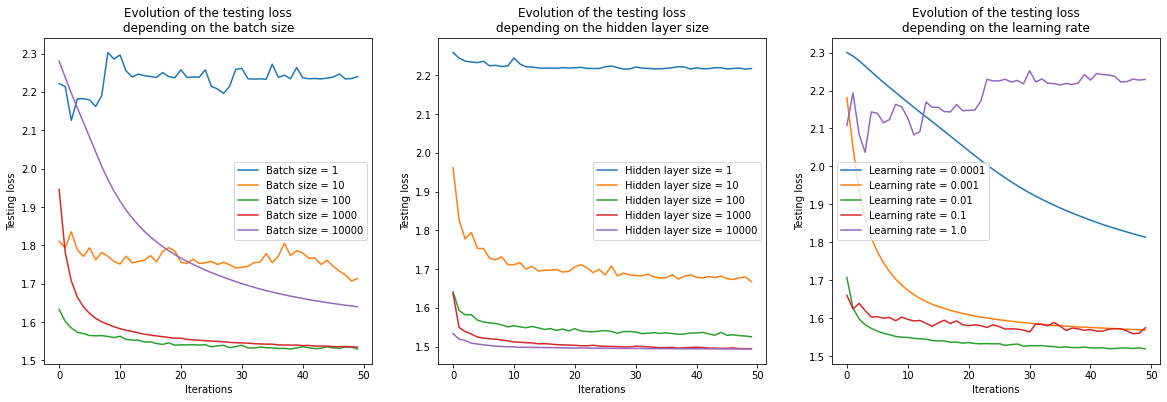

In [37]:
def plot_info(ax, variable):
    ax.set_title(f"Evolution of the testing loss\ndepending on the {variable}")
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Testing loss")
    ax.legend()

Nbatch_list = np.logspace(0, 4, 5, dtype=int)
nh_list = np.logspace(0, 4, 5, dtype=int)
eta_list = np.logspace(-4, 0, 5)

_, (nbatch_ax, nh_ax, eta_ax) = plt.subplots(1, 3, figsize=(20, 6))
print("Starting experimentation on batch size")
for Nbatch in Nbatch_list:
    torch.manual_seed(0)
    testing_loss = MNIST_training(Nbatch, 100, 0.03)
    nbatch_ax.plot(testing_loss, label=f"Batch size = {Nbatch}")

print("Starting experimentation on hidden layer size")
for nh in nh_list:
    torch.manual_seed(0)
    testing_loss = MNIST_training(100, nh, 0.03)
    nh_ax.plot(testing_loss, label=f"Hidden layer size = {nh}")

print("Starting experimentation on learning rate")
for eta in eta_list:
    torch.manual_seed(0)
    testing_loss = MNIST_training(100, 100, eta)
    eta_ax.plot(testing_loss, label=f"Learning rate = {eta}")

plot_info(nbatch_ax, "batch size")
plot_info(nh_ax, "hidden layer size")
plot_info(eta_ax, "learning rate")

Iter 0: Acc train 0.137 (2.286), acc test 0.137 (2.288)
Iter 0: Acc train 0.649 (1.869), acc test 0.652 (1.866)
Iter 0: Acc train 0.886 (1.632), acc test 0.890 (1.627)
Iter 0: Acc train 0.713 (1.952), acc test 0.720 (1.950)
Iter 0: Acc train 0.194 (2.279), acc test 0.187 (2.280)
Iter 0: Acc train 0.187 (2.257), acc test 0.183 (2.257)
Iter 0: Acc train 0.550 (2.042), acc test 0.553 (2.041)
Iter 0: Acc train 0.886 (1.628), acc test 0.893 (1.622)
Iter 0: Acc train 0.920 (1.572), acc test 0.923 (1.569)
Iter 0: Acc train 0.949 (1.524), acc test 0.942 (1.532)


Text(0.5, 1.0, 'Influence of the hidden layer size\\on the computation time\nover a single iteration')

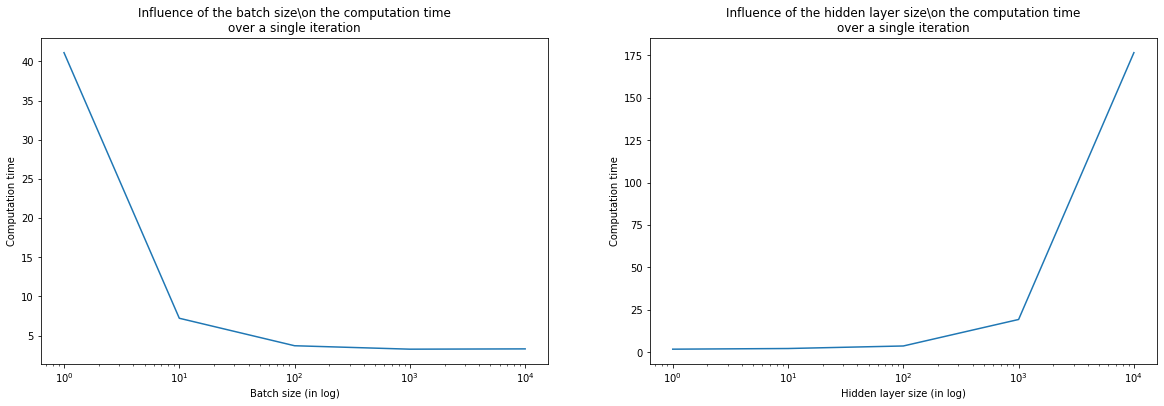

In [42]:
import time

_, (nbatch_ax, nh_ax) = plt.subplots(1, 2, figsize=(20, 6))
Nbatch_time = []
for Nbatch in Nbatch_list:
    torch.manual_seed(0)
    start = time.time()
    MNIST_training(Nbatch, 100, 0.03, nb_iterations=1)
    Nbatch_time.append(time.time() - start)

nbatch_ax.plot(Nbatch_list, Nbatch_time)
nbatch_ax.set_xlabel("Batch size (in log)")
nbatch_ax.set_xscale("log")
nbatch_ax.set_ylabel("Computation time")
nbatch_ax.set_title("Influence of the batch size\on the computation time\nover a single iteration")

nh_time = []
for nh in nh_list:
    torch.manual_seed(0)
    start = time.time()
    MNIST_training(100, nh, 0.03, nb_iterations=1)
    nh_time.append(time.time() - start)

nh_ax.plot(nh_list, nh_time)
nh_ax.set_xlabel("Hidden layer size (in log)")
nh_ax.set_xscale("log")
nh_ax.set_ylabel("Computation time")
nh_ax.set_title("Influence of the hidden layer size\on the computation time\nover a single iteration")

# Part 6: Bonus: SVM


Train a SVM model on the Circles dataset.

Ideas : 
- First try a linear SVM (sklearn.svm.LinearSVC dans scikit-learn). Does it work well ? Why ?
- Then try more complex kernels (sklearn.svm.SVC). Which one is the best ? why ?
- Does the parameter C of regularization have an impact? Why ?

In [ ]:
# data
data = CirclesData()
Xtrain = data.Xtrain.numpy()
Ytrain = data.Ytrain[:, 0].numpy()

Xgrid = data.Xgrid.numpy()

Xtest = data.Xtest.numpy()
Ytest = data.Ytest[:, 0].numpy()

def plot_svm_predictions(data, predictions):
      plt.figure(2)
      plt.clf()
      plt.imshow(np.reshape(predictions, (40,40)))
      plt.plot(data._Xtrain[data._Ytrain[:,0] == 1,0]*10+20, data._Xtrain[data._Ytrain[:,0] == 1,1]*10+20, 'bo', label="Train")
      plt.plot(data._Xtrain[data._Ytrain[:,1] == 1,0]*10+20, data._Xtrain[data._Ytrain[:,1] == 1,1]*10+20, 'ro')
      plt.plot(data._Xtest[data._Ytest[:,0] == 1,0]*10+20, data._Xtest[data._Ytest[:,0] == 1,1]*10+20, 'b+', label="Test")
      plt.plot(data._Xtest[data._Ytest[:,1] == 1,0]*10+20, data._Xtest[data._Ytest[:,1] == 1,1]*10+20, 'r+')
      plt.xlim(0,39)
      plt.ylim(0,39)
      plt.clim(0.3,0.7)
      plt.draw()
      plt.pause(1e-3)

In [ ]:
import sklearn.svm

############################
### Your code here   #######
### Train the SVM    #######
## See https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
## and https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
############################

svm = None

###########################

In [ ]:
## Print results

Ytest_pred = svm.predict(Xtest)
accuracy = np.sum(Ytest == Ytest_pred) / len(Ytest)
print(f"Accuracy : {100 * accuracy:.2f}")
Ygrid_pred = svm.predict(Xgrid)
plot_svm_predictions(data, Ygrid_pred)